In [ ]:
!pip install gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 13.9 MB/s eta 0:00:00


In [87]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from collections import deque


env = gym.make("CartPole-v1")

### Naive reinforce

In [64]:
class mlp(nn.Module):
  def __init__(self, obs, actions):
    super(mlp, self).__init__()
    self.n_actions = actions
    self.network = nn.Sequential(
        nn.Linear(obs, 256),
        nn.ReLU(),
        nn.Linear(256, actions),
        nn.Softmax(),
    )

  def forward(self, x):
    return self.network(x)

  def action(self, x):
    # x is (1, obs)
    y = self.forward(x).squeeze(0)
    action = np.random.choice(np.arange(self.n_actions), p=y.detach().cpu().numpy())
    log_prob = torch.log(y[action])
    return action, log_prob

In [79]:
gamma = 0.99
ne = mlp(env.observation_space.shape[0], env.action_space.n)


optimizer = optim.Adam(ne.parameters(), lr = 1e-3)
rolling = deque(maxlen=100)
out = []

for ep in range(1000):

  obs, _ = env.reset()
  rewards = []
  log_probs = []
  done = False

  while not done:
    ob = torch.tensor(obs).unsqueeze(0)
    action, lp = ne.action(ob)
    new_obs, reward, terminated, truncated, _ = env.step(action)
    rewards.append(reward)
    log_probs.append(lp)

    done = terminated or truncated

    obs = new_obs
  if ep % 100 == 0:
    out += list(rolling)
    print(f"Ep: {ep}, sum_rew: {sum(rolling)/ 100}")
  rolling.append(sum(rewards))

  ds_r = []

  for j in range(len(rewards)):
    pw = 0
    Gt = 0
    for r in rewards[j:]:
      Gt += gamma ** pw * r
      pw +=1
    ds_r.append(Gt)

  ds_r = torch.tensor(ds_r)
  ds_r = (ds_r - ds_r.mean()) / ds_r.std()
  lps = torch.stack(log_probs)
  pg = (-lps * ds_r).sum()

  optimizer.zero_grad()
  pg.backward()
  optimizer.step()

Ep: 0, sum_rew: 0.0
Ep: 100, sum_rew: 24.98
Ep: 200, sum_rew: 68.03
Ep: 300, sum_rew: 219.43
Ep: 400, sum_rew: 390.93
Ep: 500, sum_rew: 425.75
Ep: 600, sum_rew: 486.45
Ep: 700, sum_rew: 488.05
Ep: 800, sum_rew: 471.14
Ep: 900, sum_rew: 480.73


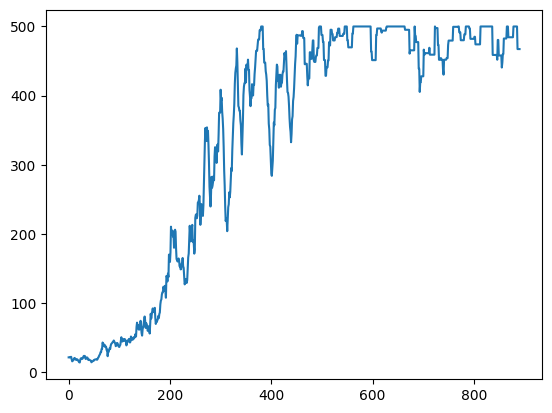

In [80]:
import matplotlib.pyplot as plt

def moving_average(data, window_size):
    cumsum = np.cumsum(np.insert(data, 0, 0))
    return (cumsum[window_size:] - cumsum[:-window_size]) / window_size

window_size = 10

smoothed_data = moving_average(out, window_size)
plt.plot(smoothed_data)

In [26]:
# https://stackoverflow.com/questions/77042526/how-to-record-and-save-video-of-gym-environment
import gymnasium as gym

###
# create a temporary variable with our env, which will use rgb_array as render mode. This mode is supported by the RecordVideo-Wrapper
tmp_env = gym.make("MountainCar-v0", render_mode="rgb_array")

# wrap the env in the record video
env = gym.wrappers.RecordVideo(env=tmp_env,video_folder="/content/sample_data",name_prefix="test-video", episode_trigger=lambda x: x % 1 == 0)

# env reset for a fresh start
obs, info = env.reset()

###
# Start the recorder


# AI logic
for _ in range(500):
    # action = env.action_space.sample()  # agent policy that uses the observation and info
    ob = torch.tensor(obs).unsqueeze(0)
    action, _ = ne.action(ob)
    obs, reward, terminated, truncated, _ = env.step(action)

    env.render()

    if terminated or truncated:
        observation, info = env.reset()


# Close the environment
env.close()

In [27]:
from IPython.display import HTML
from base64 import b64encode
import os

# Input video path
save_path = "/content/sample_data/test-video-episode-0.mp4"

# Compressed video path
compressed_path = "/content/videos/result_compressed.mp4"

os.system(f"ffmpeg -i {save_path} -vcodec libx264 {compressed_path}")

# Show video
mp4 = open(compressed_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

### Reinforce with learned baseline

In [81]:
class baseline(nn.Module):
  def __init__(self, obs):
    super(baseline, self).__init__()
    self.network = nn.Sequential(
        nn.Linear(obs, 128),
        nn.ReLU(),
        nn.Linear(128, 1),
    )

  def forward(self,x):
    return self.network(x)

In [99]:
import torch.nn.functional as F

gamma = 0.99
ne = mlp(env.observation_space.shape[0], env.action_space.n)
bl = baseline(env.observation_space.shape[0])


optimizer = optim.Adam(ne.parameters(), lr = 1e-3)
b_optim = optim.Adam(bl.parameters(), lr = 1e-2)
rolling = deque(maxlen=100)
out = []

for ep in range(1000):

  obs, _ = env.reset()
  rewards = []
  states = []
  log_probs = []
  done = False

  while not done:
    ob = torch.tensor(obs).unsqueeze(0)
    action, lp = ne.action(ob)
    new_obs, reward, terminated, truncated, _ = env.step(action)
    rewards.append(reward)
    log_probs.append(lp)
    states.append(obs)

    done = terminated or truncated

    obs = new_obs
  if ep % 100 == 0:
    out += list(rolling)
    print(f"Ep: {ep}, sum_rew: {sum(rolling)/ 100}")
  rolling.append(sum(rewards))

  ds_r = []

  for j in range(len(rewards)):
    pw = 0
    Gt = 0
    for r in rewards[j:]:
      Gt += gamma ** pw * r
      pw +=1
    ds_r.append(Gt)

  obss = torch.tensor(np.stack(states))
  ds_r = torch.tensor(ds_r).unsqueeze(-1)
  vals = bl(obss)

  loss = F.mse_loss(vals, ds_r.detach())


  ds_r = ds_r - vals.detach()
  lps = torch.stack(log_probs)
  pg = (-lps * ds_r).sum()

  optimizer.zero_grad()
  pg.backward()
  optimizer.step()

  b_optim.zero_grad()
  loss.backward()
  b_optim.step()


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Ep: 0, sum_rew: 0.0
Ep: 100, sum_rew: 38.56
Ep: 200, sum_rew: 51.98
Ep: 300, sum_rew: 90.11
Ep: 400, sum_rew: 215.18
Ep: 500, sum_rew: 194.85
Ep: 600, sum_rew: 392.31
Ep: 700, sum_rew: 283.42
Ep: 800, sum_rew: 421.19
Ep: 900, sum_rew: 352.52


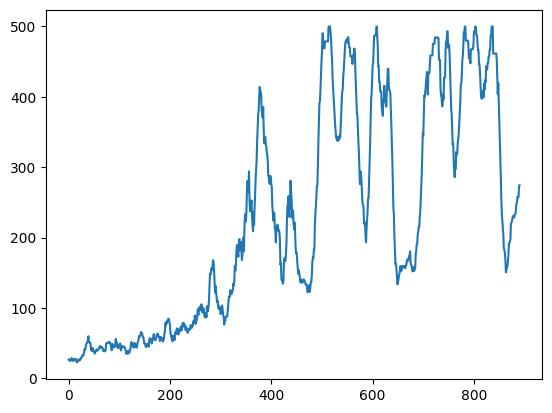

In [100]:
import matplotlib.pyplot as plt

def moving_average(data, window_size):
    cumsum = np.cumsum(np.insert(data, 0, 0))
    return (cumsum[window_size:] - cumsum[:-window_size]) / window_size

window_size = 10

smoothed_data = moving_average(out, window_size)
plt.plot(smoothed_data)